*In this notebook: 
* Unsupervised clustering of images 
* Spatial classifiers of images
* temporal clustering
* converting movies to spatio-temporal trajectories


Created on Thu Jan  7 11:12:32 2021

@author: suhail


# 1- Unsupervised clustering of images 


In [1]:
# loading/processing the images  
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 

# models 
from keras.models import Model
import pickle

# clustering, dimension reduction, feature selection
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle
import time
import timeit
import scipy
# learning classifiers
from mpl_toolkits.mplot3d import Axes3D

import regex
from scipy.io import savemat


2021-10-27 13:25:14.466141: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


## Feature Extraction using pre-trained CNN  


In [2]:
## load the pre-trained CNN model VGG16
from keras.applications.vgg16 import VGG16 
model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

## define functions for feature extraction and visualizing clusters
def extract_features(file, model):
    # load the image
    img = load_img(file, target_size=(224,224))
    img = np.array(img)
    reshaped_img = img.reshape(1,224,224,3) 
    
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features

2021-10-27 13:26:26.986396: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-27 13:26:27.060171: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/pace-apps/spack/packages/0.12/linux-rhel7-x86_64/gcc-4.8.5/gcc-8.3.0-opnwtdjumg2hxo4ljvnx77ugb6afmvj3/lib64:/usr/local/pace-apps/spack/packages/0.13/linux-rhel7-cascadelake/intel-19.0.5/mvapich2-2.3.2-hpgbkqoytbjh35qn2t63rdorepxcezek/lib:/usr/local/pace-apps/spack/packages/0.13/linux-rhel7-x86_64/gcc-4.8.5/intel-parallel-studio-cluster.2019.5-rde2uvgb2mq2x6obqaklxppmycfngjgm/itac/2019.5.041/intel64/slib:/usr/local/pace-apps/spack/packages/0.13/linux-rhel7-x86_64/gcc-4.8.5/intel-parallel-studio-cluster.2019.5-rde2uvgb2mq2x6obqaklxppmycfngjgm/compilers_and_libraries_2019.5.281/linux/compiler/lib/intel64_lin:/u

In [3]:
## Load the dataset
cwd = r'/storage/coda1/p-mkemp6/0/salsalehi3/Organoid_Suhail/Jup'
path = os.path.join(cwd,'images') # folder images contains images from multiple morpheus simulations
# change the working directory to the path where the images are located
os.chdir(path)

# this list holds all the image filename
images = []
# creates a ScandirIterator aliased as files
with os.scandir(path) as files:
  # loops through each file in the directory
    for file in files:
        if file.name.endswith('.png'): #or file.name.endswith('.jpg'):
          # adds only the image files to the images list
            images.append(file.name)
            
print('number of images ', len(images))

number of images  21950


In [ ]:
# Extracting features from images in the folder "images"
data = {}
p = r"dump"

# loop through each image in the dataset and map into feature space
start = timeit.default_timer()
for image in images:
    # try to extract the features and update the dictionary
    try:
        feat = extract_features(image,model)
        data[image] = feat
    # if something fails, save the extracted features as a pickle file (optional)
    except:
        with open(p,'wb') as file:
            pickle.dump(data,file)
            
stop = timeit.default_timer()
print('Feature extraction time for %s images is: ' %len(images), stop - start)

# get a list of the filenames
filenames = np.array(list(data.keys()))
# get a list of just the features
feat = np.array(list(data.values()))
# reshape so that there are 210 samples of 4096 vectors

feat = feat.reshape(-1,4096)
# save the feature vector to avoid running everytime 
pkl_filename = "features.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(feat, file)
    
filenames = np.array(list(images))

pkl_filename = "images_names.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(filenames, file)

"""
df = pd.read_csv('image_labels.csv')
label = df['label'].tolist()
unique_labels = list(set(label))
"""

In [4]:
pkl_filename = "features.pkl"
feat = pickle.load(open(pkl_filename, 'rb'))
pkl_filename = "images_names.pkl"
filenames = pickle.load(open(pkl_filename, 'rb'))
# run this part if you want to use reduced feature vector
# pkl_filename = "selected_features.pkl"
# ind_feat_red = pickle.load(open(pkl_filename, 'rb'))
# X_clstr = feat[:,ind_feat_red]
# X_clstr.shape

## Clustering

Fitting time:  18.2550794724375 number of clusters :  5


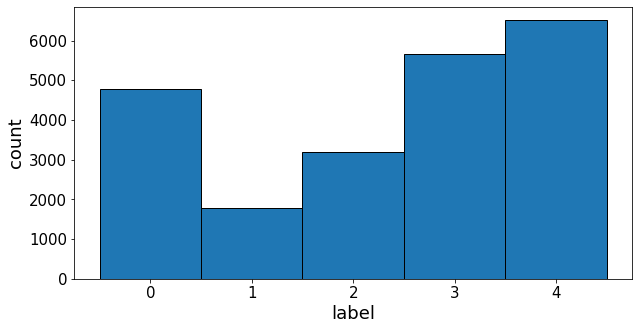

In [10]:
# cluster feature vectors into "no_clusters" clusters
no_clusters = 5

start = timeit.default_timer()
kmeans = KMeans(n_clusters=no_clusters, random_state=22) # change number of clusters here
kmeans.fit(feat)
stop = timeit.default_timer()
print('Fitting time: ', stop - start, 'number of clusters : ',no_clusters )
# holds the cluster id and the images { id: [images] }
groups = {}
count = 0 

# Order labels in a biologically meaningful order
klabels = kmeans.labels_
klabels= [100 if x==3 else x for x in klabels]
klabels= [200 if x==0 else x for x in klabels]
klabels= [300 if x==4 else x for x in klabels]
klabels= [400 if x==2 else x for x in klabels]
klabels= [500 if x==1 else x for x in klabels]
klabels= [0 if x==100 else x for x in klabels]
klabels= [1 if x==200 else x for x in klabels]
klabels= [2 if x==300 else x for x in klabels]
klabels= [3 if x==400 else x for x in klabels]
klabels= [4 if x==500 else x for x in klabels]
y=[]

for file, cluster in zip(filenames,klabels):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)
    y.append (cluster)
    count = count+1

y = np.array(y)
############## save data with labels ###################
# cwd = os.getcwd()
# print(cwd)
# pkl_filename ='patterns.pkl'
# with open(pkl_filename, 'wb') as file:
#     pickle.dump(groups, file)
# savemat('patterns.mat',{"image_name":filenames,"image_label":kmeans.labels_})

# plot number of images per class 
counts, bins = np.histogram(y)
fig, ax = plt.subplots(figsize=(10,5))
ax.hist(y, np.arange(0,6)-1+0.5, ec="k")
plt.title('')
plt.xlabel('label', fontsize=18)
plt.ylabel('count', fontsize=18)
plt.xticks(fontsize=15 )
plt.yticks(fontsize=15 )

plt.show()
ax.locator_params(axis='x', integer=True)

class number:  0
Clipping cluster size from 4785 to 30
class number:  1
Clipping cluster size from 1788 to 30
class number:  2
Clipping cluster size from 3201 to 30
class number:  3
Clipping cluster size from 5656 to 30
class number:  4
Clipping cluster size from 6520 to 30


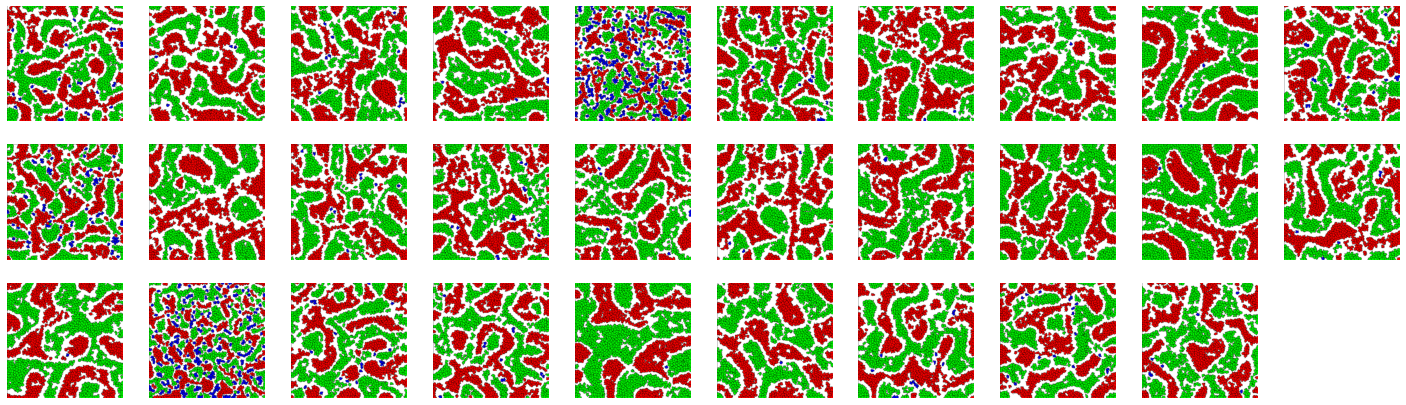

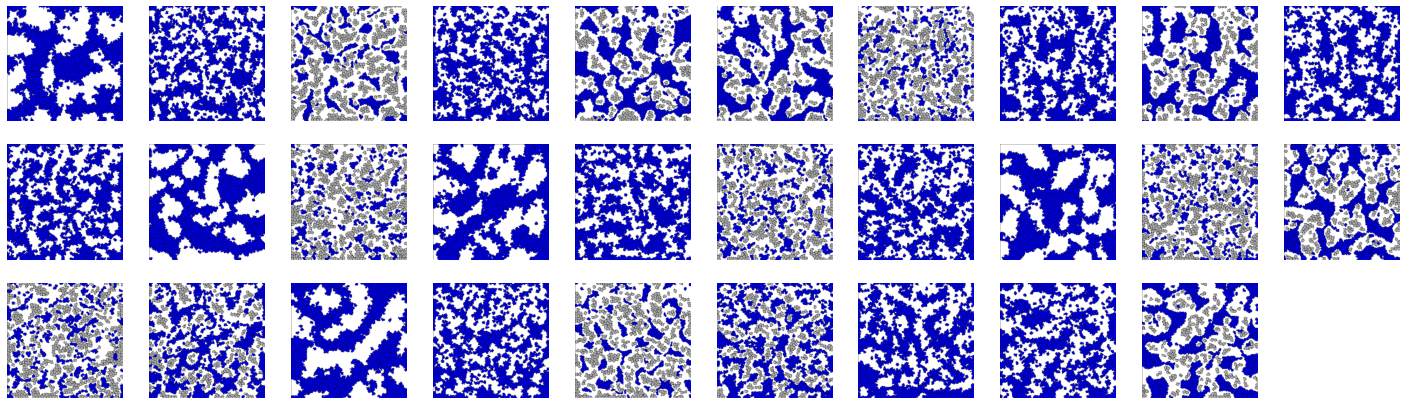

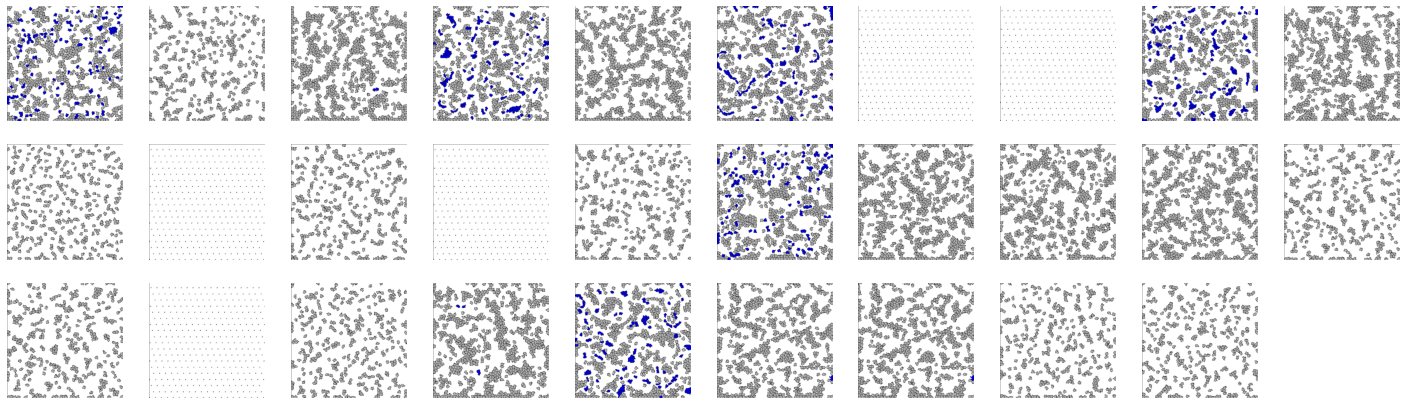

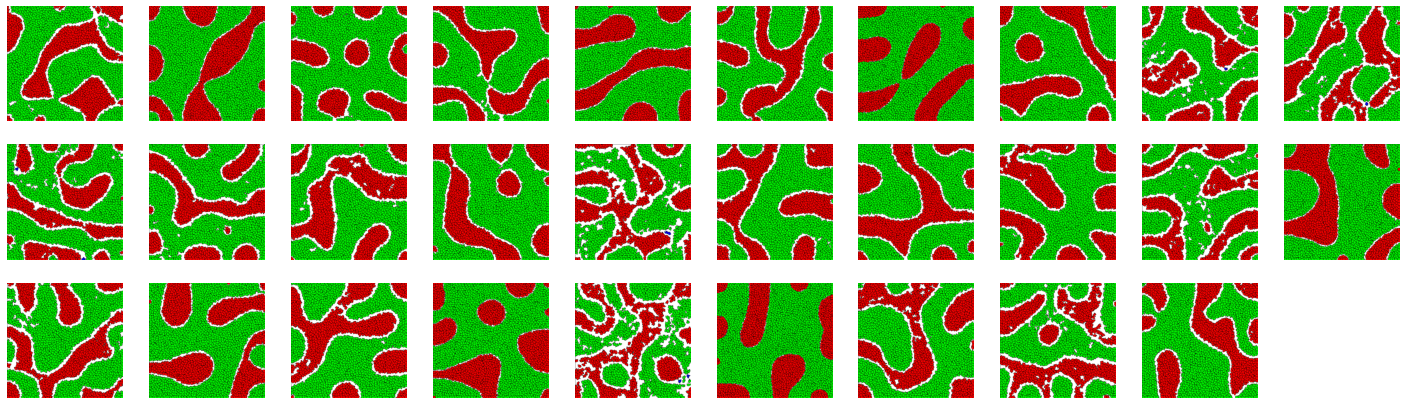

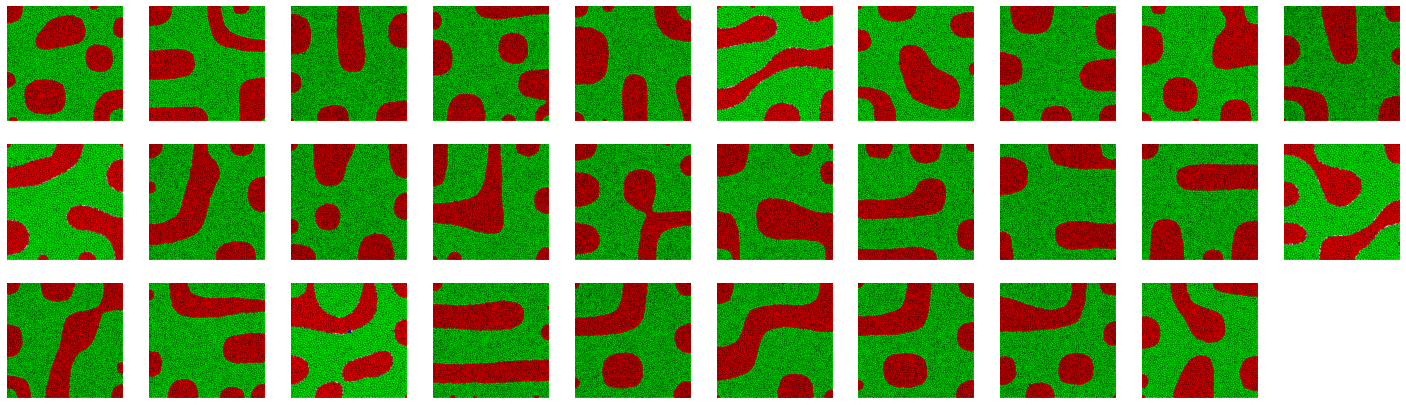

In [11]:
# view the resultant clusters 
def view_cluster(cluster):
    plt.figure(figsize = (25,25));
    # gets the list of filenames for a cluster
    files = groups[cluster]
    # only allow up to 30 images to be shown at a time
    if len(files) > 30:
        print(f"Clipping cluster size from {len(files)} to 30")
        files = files[len(files)-29:len(files)]
    # plot each image in the cluster
    for index, file in enumerate(files):
        #print(file)
        plt.subplot(10,10,index+1);
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')
        
for i in range(no_clusters):
    print('class number: ', i)
    view_cluster(i)

<b>Visualizations using t-distributed stochastic neighbor embedding (TSNE)</b>

In [ ]:
import sklearn.decomposition
import sklearn.manifold
import sklearn.linear_model
n = 100 #can adjust this to improve visualization
PCA_reduced = sklearn.decomposition.PCA(n_components=n).fit_transform(feat) #reduced dimensionality for TSNE

TSNE_embed = sklearn.manifold.TSNE(n_components=2, perplexity=300).fit_transform(PCA_reduced) #adjusting perplexity also can improve the visualization
plt.scatter(TSNE_embed[:,0], TSNE_embed[:,1], c=y)

## Feature selection

In [ ]:
# #############################################################################
# prepare data for feature selection
X =feat #n_samples * n_genes
y = y #age group
np.random.seed(0)
# X = np.hstack((X, 2 * np.random.random((X.shape[0], 36))))

# #############################################################################
# Create a feature-selection transform, a scaler and an instance of SVM that we
# combine together to have an full-blown estimator
clf = Pipeline([('anova', SelectPercentile(chi2)),
                ('scaler', StandardScaler()),
                ('svc', SVC(gamma="auto"))])

# #############################################################################
# Plot the cross-validation score as a function of percentile of features
score_means = list()
score_stds = list()
percentiles = (1, 3, 6, 10, 15, 20, 30, 40, 60, 80, 100)

# for percentile in percentiles:
#     clf.set_params(anova__percentile=percentile)
#     this_scores = cross_val_score(clf, X, y)
#     score_means.append(this_scores.mean())
#     score_stds.append(this_scores.std())

# plt.errorbar(percentiles, score_means, np.array(score_stds))
# plt.title(
#     'Performance of the SVM-Anova varying the percentile of features selected')
# plt.xticks(np.linspace(0, 100, 11, endpoint=True))
# plt.xlabel('Percentile')
# plt.ylabel('Accuracy Score')
# plt.axis('tight')

# plt.show()

start = timeit.default_timer()
            
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

log_reg2 = sklearn.linear_model.LogisticRegressionCV(cv=5, Cs=[0.01, 0.1, 1, 10],
                                                    max_iter=5000,
                                                    penalty='l2', solver='liblinear',
                                                    multi_class='ovr')

log_reg2.fit(X_train,y_train) #this needs to be on a subset of new data for correct scores, here we use the test data

log_reg2_training_validation_score = log_reg2.score(X_train,y_train) #getting the cross validation score

print('Training validation score')
print(log_reg2_training_validation_score)

log_reg2_training_validation_score = log_reg2.score(X_test, y_test) #getting the cross validation score

print('Testing validation score')
print(log_reg2_training_validation_score)
stop = timeit.default_timer()

# select features based on best logistic regression coefficient
CV_coefficients = log_reg2.coef_ #finding coefficients of the logistic regression equation (there will be a column of coeff for each feature fot each class, so a 5x4096 matrix)
Sum_coef = np.sum(np.abs(CV_coefficients), axis=0) #summing the coeff by class to get 1x4096 
Num_features = 20 #can change this to increase accuracy 
ind_feat_red = Sum_coef.argsort()[-Num_features:] #select n features with largest overall coefficients 

cwd = os.getcwd()
print(cwd)
pkl_filename = "selected_features.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(ind_feat_red, file)
    


In [ ]:
# test the selected features by training a new logistic regression model
X_red = X[:,ind_feat_red]
print('Data after dimentionality reduction is of shape', X_red.shape)

X_train, X_test, y_train, y_test = train_test_split(X_red, y, test_size=0.33, random_state=42)

log_reg2 = sklearn.linear_model.LogisticRegressionCV(cv=5, Cs=[0.01, 0.1, 1, 10],
                                                    max_iter=5000,
                                                    penalty='l2', solver='liblinear',
                                                    multi_class='ovr')

log_reg2.fit(X_train,y_train) #this needs to be on a subset of new data for correct scores, here we use the test data

log_reg2_training_validation_score = log_reg2.score(X_train,y_train) #getting the cross validation score

print('Training validation score')
print(log_reg2_training_validation_score)

log_reg2_training_validation_score = log_reg2.score(X_test, y_test) #getting the cross validation score

print('Testing validation score')
print(log_reg2_training_validation_score)

## 2- Learning SVM classifiers


In [ ]:
# use the reduced feature vector 
# X_red = X[:,ind_feat_red]
X_red = X_clstr
y = y

# split data for training and testing

X_train, X_test, y_train, y_test = train_test_split(X_red, y, test_size=0.33,random_state=10)
print (X_train.shape , X_test.shape)
n_samples, n_features = X_train.shape
print('number of samples and features')
print(n_samples, n_features)
# learn SVM Classifiers
### C - SVM regularization parameter 
start = timeit.default_timer()
classifier= svm.SVC(kernel='linear', C=0.1, probability=True,decision_function_shape='ovr', verbose= True).fit(X_train, y_train)
stop = timeit.default_timer()
print('Training time: ', stop - start)
print('Training classification score:')
print (classifier.score(X_train, y_train))
print('Testing classification score:')
print (classifier.score(X_test, y_test))

# Save to file in the current working directory
pkl_filename = "spatial_classifiers_ovr_red.pkl" #change the name if needed
with open(pkl_filename, 'wb') as file:
    pickle.dump(classifier, file)

coef=classifier.coef_
intercept=classifier.intercept_
OutInCoef=coef[6]
OutInIntercept= intercept[6]
print (OutInCoef, '\n' ,  OutInIntercept)

cwd = os.getcwd()
print('current directory :',cwd)

In [ ]:
x_test.shape

<b>Test learned SVM classifiers on new images

In [ ]:
## upload existing classifier?
pkl_filename = "spatial_classifiers_ovr_red.pkl"
classifier = pickle.load(open(pkl_filename, 'rb'))
    
# test the classifier with new images
path = r"/storage/coda1/p-mkemp6/0/salsalehi3/Organoid_Suhail/Jup/images_test"
os.chdir(path)

# this list holds all the image filename
images_test = []
#upload images
with os.scandir(path) as files:
  # loops through each file in the directory
    for file in files:
        if file.name.endswith('.png'):
          # adds only the image files to the images list
            images_test.append(file.name)
data_test = {}
p = r"dump"

# extract features
for image in images_test:
    # try to extract the features and update the dictionary
    try:
        x_test = extract_features(image,model)
        data_test[image] = x_test
    # if something fails, save the extracted features as a pickle file (optional)
    except:
        print('error occurred')
        with open(p,'wb') as file:
            pickle.dump(x_test,file)
            
# get a list of the filenames
filenames_test = np.array(list(data_test.keys()))
# get a list of just the features
x_test = np.array(list(data_test.values()))
# reshape so that there are 210 samples of 4096 vectors
x_test = x_test.reshape(-1,4096)

# use only the selected features 
for image_ind in data_test:
    x_test = data_test[image_ind]
    x_test_red =x_test[:,ind_feat_red]
    ccc = classifier.predict(x_test_red.reshape(1,-1))
    print('class number predicted:',ccc)
    dist_ = classifier.decision_function(x_test_red.reshape(1,-1))
    print('Predict confidence scores:',dist_)
#     dist = np.zeros((10, 10))
#     dist[np.tril_indices(10,-1)] = dist_  
#     print('Predict confidence scores:',dist)
    # The confidence score for a sample is proportional to the signed distance of that sample to the hyperplane.
    plt.imshow(dist_)
    plt.grid(True)
    plt.show()
    
    print(image_ind)
    img = load_img(image_ind)
    img = np.array(img)
    plt.imshow(img)
    plt.show()
    path = r"/storage/coda1/p-mkemp6/0/salsalehi3/Organoid_Suhail/Jup/images"
    # change the working directory to the path where the images are located
    os.chdir(path)
    view_cluster(ccc[0])
    path = r"/storage/coda1/p-mkemp6/0/salsalehi3/Organoid_Suhail/Jup/images_test"
    # change the working directory to the path where the images are located
    os.chdir(path)

In [ ]:
ind_feat_red

# Temporal Clustering
* first we extract features from simulations using a pre-trained CNN
* we further process data by mapping it to a new lower dimensional space corresponding to euclidean distances to  

In [ ]:
"""
Created on Thu Jan  7 11:12:32 2021
@author: suhail
"""
# loading/processing the images  
import cv2
from IPython.display import Video
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 

# models 
from keras.models import Model
import pickle

# clustering, dimension reduction, feature selection
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# learning classifiers
from mpl_toolkits.mplot3d import Axes3D

from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle
import time
from scipy.io import savemat

# package for plotting dendograms 
from scipy.cluster.hierarchy import dendrogram, linkage

cwd = os.getcwd()
print(cwd)
cwd = r'/storage/coda1/p-mkemp6/0/salsalehi3/Organoid_Suhail/Jup'

In [ ]:
# Load necessary models and directories
# CNN model
from keras.applications.vgg16 import VGG16 
CNN_model = VGG16()
CNN_model = Model(inputs = CNN_model.inputs, outputs = CNN_model.layers[-2].output)

# SVM model
pkl_filename = r'/storage/coda1/p-mkemp6/0/salsalehi3/Organoid_Suhail/spatial_classifiers_ovr_red.pkl'
SVM_model = pickle.load(open(pkl_filename, 'rb'))

# indecies of selected features
pkl_filename = r"/storage/coda1/p-mkemp6/0/salsalehi3/Organoid_Suhail/Jup/images_test/selected_features.pkl"
selected_features = pickle.load(open(pkl_filename, 'rb'))

In [ ]:

def extract_features(file, CNN_model):
    ## Function to extract features from still images
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224,224))
    # convert  to numpy array
    img = np.array(img) 
    reshaped_img = img.reshape(1,224,224,3) 
    
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = CNN_model.predict(imgx, use_multiprocessing=True)
    return features

def getList(dict): 
    return list(dict.keys())

def extract_trace(path, CNN_model,SVM_model):
    #upload the indecies of selected features
    path_temp = r"/storage/coda1/p-mkemp6/0/salsalehi3/Organoid_Suhail/Jup/images_test/"
    os.chdir(path_temp)
    pkl_filename = "selected_features.pkl"
    ind_feat_red = pickle.load(open(pkl_filename, 'rb'))
        
    # upload 
    os.chdir(path)
    images = []
    # creates a ScandirIterator aliased as files
    with os.scandir(path) as files:
      # loops through each file in the directory
        for file in files:
            if file.name.endswith('.png'): #or file.name.endswith('.jpg'):
              # adds only the image files to the images list
                images.append(file.name)
              
    dic_img = {}
    p = r"dump"
    traj_dist =[]
    labels = []
    # loop through each image in the dataset
    only_class_labels = []
    for index, image in enumerate (sorted(images)):
        if index>=45:
            break
        # try to extract the features and update the dictionary
        image_name= os.path.splitext(image)[0]
        try:
            feat = extract_features(image,CNN_model)
            feat = feat[:,ind_feat_red]
            label = SVM_model.predict(feat.reshape(1,-1))
            arr = SVM_model.decision_function(feat.reshape(1,-1)).reshape(-1,1)
            traj_dist.append(arr.tolist()) 
            labels.append(int(label[0]))
            dic_img[image_name]= (labels,traj_dist,feat.tolist())
        # if something fails, save the extracted features as a pickle file (optional)
        except Exception as e: 
            print(e)
            print('failed')
            with open(p,'wb') as file:
                pickle.dump(data,file)

    # get a list of the filenames
    filenames = np.array(list(dic_img.keys()))
    return filenames, labels,traj_dist, dic_img 

In [ ]:
## convert the movies into spatio-temporal trajectories


# uncomment to upload previously converted spatio-temporal trajectories
# If uploading, don't forget to comment the rest of the cell
"""
rootdir = r"/storage/coda1/p-mkemp6/0/salsalehi3/Organoid_Suhail/Jup/simulations/"
os.chdir(rootdir)

with open('traces.pkl', 'rb') as pickle_load:
    my_list =pickle.load(pickle_load)
    
with open('names.pkl', 'rb') as pickle_load:
    image_names =pickle.load(pickle_load)
# print the array
print(len(my_list[3]))
"""

# directory where simulations are stored
rootdir = r"/storage/coda1/p-mkemp6/0/salsalehi3/Organoid_Suhail_data/"

traces=[]
data_run={}
image_names=[]
labels_run_im = []
run_names_full=[]
run_names =[]
traj_dist =[]
counter =0
for root, subdirs, files in os.walk(rootdir):
    for run_name_full in sorted(subdirs):
        path = os.path.join(root, run_name_full)
        print(path)
        run_name = ''.join(e for e in run_name_full if e.isalnum())
        image_names_temp, labels_temp,traj_dist_temp,data_temp = extract_trace(path, CNN_model,SVM_model)
        if len(labels_temp)>=45:
            run_names.append(run_name)
            run_names_full.append(run_name_full)
            image_names.append(image_names_temp[:45])
            labels_run_im.append(labels_temp[:45])  
            traj_dist.append(traj_dist_temp[:45])     
            data_run[run_name]= (run_name_full,image_names_temp[:45],labels_temp[:45],traj_dist_temp[:45],data_temp)
            

w_norm = np.linalg.norm(SVM_model.coef_)
traj_dist = traj_dist / w_norm
rootdir = r"/storage/coda1/p-mkemp6/0/salsalehi3/Organoid_Suhail/Jup/simulations"
os.chdir(rootdir)
print('image_names', len(image_names[0]))
print('labels_run_im', len(labels_run_im[0]))
print('traj_dist', len(traj_dist[0]))


with open('run_names_full.pkl', 'wb') as pickle_file:
    pickle.dump(run_names_full, pickle_file, protocol=pickle.HIGHEST_PROTOCOL)
with open('image_names.pkl', 'wb') as pickle_file:
    pickle.dump(image_names, pickle_file, protocol=pickle.HIGHEST_PROTOCOL)
with open('labels_run_im.pkl', 'wb') as pickle_file:
    pickle.dump(labels_run_im, pickle_file, protocol=pickle.HIGHEST_PROTOCOL)
with open('traj_dist.pkl', 'wb') as pickle_file:
    pickle.dump(traj_dist, pickle_file, protocol=pickle.HIGHEST_PROTOCOL)
with open('data_run.pkl', 'wb') as pickle_file:
    pickle.dump(data_run, pickle_file, protocol=pickle.HIGHEST_PROTOCOL)
    
# save a copy for matlab use
savemat('run_names_full.mat',{"run_names_full":run_names_full})
savemat('image_names.mat',{"image_names":image_names})
savemat('labels_run_im.mat',{"labels_run_im":traj_dist})
savemat('traj_dist.mat', {"traj_dist":labels_run_im})
savemat('data_run.mat', data_run)

# ## Generate data for learning from features directly
# rootdir = r"/storage/coda1/p-mkemp6/0/salsalehi3/Organoid_Suhail/Jup/images"
# os.chdir(rootdir)
# pkl_filename = "selected_features.pkl"
# ind_selected_feat = pickle.load(open(pkl_filename, 'rb'))
# rootdir = r"/storage/coda1/p-mkemp6/0/salsalehi3/Organoid_Suhail/Jup/simulations"
# os.chdir(rootdir)
# feat_latest ={}
# feat_red ={}
# foot ={}
# for key1 in data_run.keys():
#     foot = data_run [key1][4]
#     feat_latest ={}
#     for index, key2 in enumerate(foot.keys()):
#         TEMPP = foot[key2] 
#         feat_latest[key2] =np.array(TEMPP[2][0])[ind_selected_feat.astype(int)]
#     feat_red[key1]=feat_latest
# savemat('Trajs_of_features.mat', feat_red)  

In [ ]:
w_norm = np.linalg.norm(SVM_model.coef_)
traj_dist = traj_dist / w_norm
SVM_model.support_vectors_.shape

In [ ]:
# ## upload existing files 
# rootdir = r"/storage/coda1/p-mkemp6/0/salsalehi3/Organoid_Suhail/Jup/simulations"
# os.chdir(rootdir)
# pkl_filename = 'run_names_full.pkl'
# run_names_full = pickle.load(open(pkl_filename, 'rb'))
# pkl_filename = 'image_names.pkl'
# image_names = pickle.load(open(pkl_filename, 'rb'))
# pkl_filename = 'labels_run_im.pkl'
# labels_run_im = pickle.load(open(pkl_filename, 'rb'))
# pkl_filename = 'traj_dist.pkl'
# traj_dist = pickle.load(open(pkl_filename, 'rb'))
# pkl_filename = 'data_run.pkl'
# data_run = pickle.load(open(pkl_filename, 'rb'))
# rootdir = r"/storage/coda1/p-mkemp6/0/salsalehi3/Organoid_Suhail/Jup/images"
# os.chdir(rootdir)
# pkl_filename = "selected_features.pkl"
# ind_selected_feat = pickle.load(open(pkl_filename, 'rb'))
# rootdir = r"/storage/coda1/p-mkemp6/0/salsalehi3/Organoid_Suhail/Jup/simulations"
# os.chdir(rootdir)
# # save to matlab
# rootdir = r"F/storage/coda1/p-mkemp6/0/salsalehi3/Organoid_Suhail/Jup/images"
# os.chdir(rootdir)
# pkl_filename = "selected_features.pkl"
# ind_selected_feat = pickle.load(open(pkl_filename, 'rb'))
# ind_selected_feat
# savemat('ind_selected_feat.mat', {"foo":ind_selected_feat})

In [ ]:
# function for temporal clustering (taken from )
def nTreeClus(my_list, n = None, method = "All", ntree = 10, C = None):
    """ nTreeClus is a clustering method by Mustafa Gokce Baydogan and Hadi Jahanshahi.
    The method is suitable for clustering categorical time series (sequences). 
    You can always have access to the examples and description in 
    https://github.com/HadiJahanshahi/nTreeClus
    If you have any question about the code, you may email hadijahanshahi [a t] gmail . com
    
    prerequisites:
        numpy
        pandas
        sklearn
        scipy
    
    Args:
        my_list: a list of sequences to be clustered
        n: "the window length" or "n" in nTreecluss, you may provide it or it will be
            calculated automatically if no input has been suggested.
        method: 
            DT: Decision Tree
            RF: Random Forest
            All: both methods
        ntree: number of trees to be used in RF method. The defualt value is 10. 
             (Being too small has a bad effect on accuracy and being too large increases the complexity. 
              no less than 5 and no greater than 20.)
        C: number of clusters if it is not provided, it will be calculated for 2 to 10.

    Returns:
        'C_DT': "the optimal number of clusters with the aid of Decision Tree",
        'C_RF': "the optimal number of clusters with the aid of Random Forest",
        'Parameter n': the parameter of the nTreeClus (n) - either calculated or manually given
        'distance_DT': "sparse disance between sequences with the aid of Decision Tree",
        'distance_RF': "sparse disance between sequences with the aid of Random Forest",
        'labels_DT': "labels based on the optimal number of clusters using DT",
        'labels_RF': "labels based on the optimal number of clusters using RF".
            
            NOTE: in order to convert the distance output to a square distance matrix, 
                "scipy.spatial.distance.squareform" should be used.
                
    ## simple example with the output
    my_list = ['evidence','evident','provide','unconventional','convene']
    nTreeClusModel = nTreeClus(my_list, method = "All")
    # {'C_DT': 2,
    # 'C_RF': 2,
    # 'distance_DT': array([ 0.05508882,  0.43305329,  0.68551455,  0.43305329,  0.5       ,
    #         0.7226499 ,  0.5       ,  0.86132495,  0.75      ,  0.4452998 ]),
    # 'distance_RF': array([ 0.0809925 ,  0.56793679,  0.42158647,  0.57878823,  0.56917978,
    #         0.47984351,  0.54545455,  0.55864167,  0.71278652,  0.3341997 ]),
    # 'labels_DT': array([0, 0, 0, 1, 1]),
    # 'labels_RF': array([0, 0, 0, 1, 1])}
    
    
    """
    ############# pre processisng #################
    import numpy as np
    import pandas as pd
    from sklearn import preprocessing
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.tree import DecisionTreeClassifier
    import scipy.spatial.distance as ssd
    from scipy.cluster.hierarchy import linkage
    from sklearn.metrics import silhouette_score 
    from scipy import cluster

    
    sequence_sep = pd.DataFrame(my_list) # create a DataFrame out of the given list
    #sequence_sep = pd.DataFrame([list(x) for x in sequence[0]]) # separating the sequence
    sequence_sep[sequence_sep.shape[1]] = None # adding an empty column to the end of sequence

    if n is None:
        min_length = min( map(len, my_list) )
        total_avg = round(sum( map(len, my_list) ) / len(my_list)) # average length of strings
        n = min (round(total_avg**0.5) + 1, min_length - 1)
    
    if (n < 3):
        raise ValueError("Parameter n could not be less than 3. Remove the sequences with the length shorter than 3 and then re-run the function.")
    
    
    ############# matrix segmentation #################
    firstiteration = 1
    for i in range(len(my_list)):
        for j in range(sequence_sep.shape[1]):
            if (j < np.min(np.where(sequence_sep.iloc[i].isnull())) - n + 1): #check where is the position of the first "None"
                if (firstiteration==1):
                    seg_mat = pd.DataFrame(sequence_sep.iloc[i,j:j+n]).transpose()
                    seg_mat['OriginalMAT_element'] = i
                    seg_mat.columns = [np.arange(0,n+1)]
                    firstiteration+=1
                else:
                    temp = pd.DataFrame(sequence_sep.iloc[i,j:j+n]).transpose()
                    temp['OriginalMAT_element'] = i
                    temp.columns = [np.arange(0,n+1)]
                    seg_mat = seg_mat.append(temp)
    seg_mat.columns = np.append(np.arange(0,n-1),('Class','OriginalMAT_element')) # renaming the column indexes
    # dummy variable for DT and RF
    le = preprocessing.LabelEncoder()
    seg_mat.loc[:,'Class'] = le.fit_transform(seg_mat.loc[:,'Class']) #make Y to numbers
    #creating dummy columns for categorical data; one-hot encoding
    seg_mat = pd.get_dummies(seg_mat).reset_index(drop=True)

    
    xtrain = seg_mat.drop(labels=['OriginalMAT_element','Class'],axis=1)
    ytrain = seg_mat['Class']

    ############# nTreeClus method using DT #################        
    if (method == "All") or (method == "DT"):
        dtree = DecisionTreeClassifier()
        fitted_tree = dtree.fit(X=xtrain,y=ytrain)
        predictiontree = dtree.predict(xtrain)
        ### finding the terminal nodes.
        terminal_tree = fitted_tree.tree_.apply(xtrain.values.astype('float32'))  #terminal output
        terminal_output_tree  = pd.DataFrame(terminal_tree)
        terminal_output_tree ['OriginalMAT_element'] = seg_mat['OriginalMAT_element'].values
        #terminal_output_tree.drop(labels=0,axis=1,inplace=True)
        terminal_output_tree.columns = ['ter','OriginalMAT_element']
        terminal_output_tree_F = pd.crosstab(terminal_output_tree.OriginalMAT_element,terminal_output_tree.ter)
        Dist_tree_terminal_cosine = ssd.pdist(terminal_output_tree_F,metric='cosine')
        HC_tree_terminal_cosine = linkage(Dist_tree_terminal_cosine, 'ward')
        #finding the number of clusters
        if C is None:
            max_clusters = min(11,len(my_list))
            ress_sil = []
            for i in range(2,max_clusters):
                assignment_tree_terminal_cosine = cluster.hierarchy.cut_tree(HC_tree_terminal_cosine,i).ravel() #.ravel makes it 1D array.
                ress_sil.append((silhouette_score(ssd.squareform(Dist_tree_terminal_cosine),assignment_tree_terminal_cosine,metric='cosine').round(3)*1000)/1000)
            C = ress_sil.index(max(ress_sil)) + 2        
        # assigning the correct label
        optimal_cluster_tree = C
        assignment_tree_terminal_cosine = cluster.hierarchy.cut_tree(HC_tree_terminal_cosine,C).ravel() #.ravel makes it 1D array.
    
        
    ############# nTreeClus method using RF #################        
    if (method == "All") or (method == "RF"):
        np.random.seed(123)
        forest = RandomForestClassifier(n_estimators= ntree ,max_features = 0.36)
        fitted_forest = forest.fit(X=xtrain,y=ytrain)
        predictionforest = forest.predict(xtrain)
        ### Finding Terminal Nodes
        terminal_forest = fitted_forest.apply(xtrain) #terminal nodes access
        terminal_forest = pd.DataFrame(terminal_forest)
        #Adding "columnindex_" to the beginning of all  
        terminal_forest = terminal_forest.astype('str')
        for col in terminal_forest:
            terminal_forest[col] = '{}_'.format(col) + terminal_forest[col]
        terminal_forest.head()
        for i in range(terminal_forest.shape[1]):
            if i == 0:
                tempor = pd.concat( [seg_mat['OriginalMAT_element'] , terminal_forest[i]],ignore_index=True,axis=1)
                rbind_terminal_forest = tempor
            else:
                tempor = pd.concat( [seg_mat['OriginalMAT_element'] , terminal_forest[i]],ignore_index=True,axis=1)
                rbind_terminal_forest = pd.concat ([rbind_terminal_forest, tempor],ignore_index=True)

        rbind_terminal_forest.columns = ['OriginalMAT_element','ter']
        terminal_output_forest_F = pd.crosstab(rbind_terminal_forest.OriginalMAT_element,rbind_terminal_forest.ter)
        Dist_RF_terminal_cosine = ssd.pdist(terminal_output_forest_F,metric='cosine')
        HC_RF_terminal_cosine = linkage(Dist_RF_terminal_cosine, 'ward')
        #finding the number of clusters
        if C is None:
            max_clusters = min(11,len(my_list))
            ress_sil = []
            for i in range(2,max_clusters):
                assignment_RF_terminal_cosine = cluster.hierarchy.cut_tree(HC_RF_terminal_cosine,i).ravel() #.ravel makes it 1D array.
                ress_sil.append((silhouette_score(ssd.squareform(Dist_RF_terminal_cosine),assignment_RF_terminal_cosine,metric='cosine').round(3)*1000)/1000)
            C = ress_sil.index(max(ress_sil)) + 2        
        # assigning the correct label
        optimal_cluster_RF = C
        assignment_RF_terminal_cosine = cluster.hierarchy.cut_tree(HC_RF_terminal_cosine,C).ravel() #.ravel makes it 1D array.

    ############# output #################                
    if (method == "All"):
        return {"distance_DT":Dist_tree_terminal_cosine, "labels_DT":assignment_tree_terminal_cosine, "C_DT":optimal_cluster_tree, "distance_RF":Dist_RF_terminal_cosine, "labels_RF": assignment_RF_terminal_cosine, "C_RF":optimal_cluster_RF, "Parameter n":n}
    elif (method == "DT"):
        return {"distance_DT":Dist_tree_terminal_cosine, "labels_DT":assignment_tree_terminal_cosine, "C_DT":optimal_cluster_tree, "Parameter n":n}
    else: 
        return {"distance_RF":Dist_RF_terminal_cosine, "labels_RF":assignment_RF_terminal_cosine, "C_DT":optimal_cluster_RF, "Parameter n":n}


In [ ]:
#simple example with the output 
nTreeClusModel = nTreeClus(labels_run_im, method = "All",ntree = 10, C=3)
# nTreeClusModel

In [ ]:
# plotting dendograms
HC_tree_terminal_cosine = linkage(nTreeClusModel["distance_DT"], 'ward')
fig = plt.figure(figsize=(25, 10))
ax = fig.add_subplot(1, 1, 1)
dendrogram(HC_tree_terminal_cosine,labels=run_names, ax=ax)
ax.tick_params(axis='x', which='major', labelsize=10)
ax.tick_params(axis='y', which='major', labelsize=15)
plt.show()

HC_RF_terminal_cosine = linkage(nTreeClusModel["distance_RF"], 'ward')
fig = plt.figure(figsize=(25, 10))
ax = fig.add_subplot(1, 1, 1)
dendrogram(HC_RF_terminal_cosine,labels=run_names, ax=ax)
ax.tick_params(axis='x', which='major', labelsize=10)
ax.tick_params(axis='y', which='major', labelsize=15)
plt.show()

In [ ]:
os.getcwd()

In [ ]:
labels_run=nTreeClusModel["labels_DT"]
all = list(zip(run_names,run_names_full,labels_run_im,traj_dist, labels_run))
# print(len(all))
# print(all[0])

savemat('all_svm_ovr45.mat',dict(names =run_names, labels_run_im =labels_run_im,labels_run = labels_run, traj_dist =traj_dist ))
savemat('all.mat', dict(all=all))
with open('all_LTI.pkl', 'wb') as pickle_file:
    pickle.dump(all, pickle_file, protocol=pickle.HIGHEST_PROTOCOL)
    
#savemat('data_all.mat',data)
#with open('name_trace_label.pkl', 'rb') as pickle_load:
#    b =pickle.load(pickle_load)

In [ ]:
def getDuplicatesWithCount(names,listOfLists):
    ''' Get frequency count of duplicate elements in the given list '''
    dictOfLists = dict()
    dictOfFormulae = dict()
    i=0
    # Iterate over each element in list
    for listOfElems in listOfLists:
        dictOfElems = dict()
        for elem in  listOfElems:
        # If element exists in dict then increment its value else add it in dict
            if elem in dictOfElems:
                dictOfElems[elem] += 1
            else:
                dictOfElems[elem] = 1  
    # Filter key-value pairs in dictionary. Keep pairs whose value is greater than 1 i.e. only duplicate elements from list.
        dictOfElems = { key:value for key, value in dictOfElems.items() if value > 0}
        time2=0
        dictOfFormula = dict()
        for key, value in dictOfElems.items():
            time1= time2
            time2=time1+500*value    
            dictOfFormula[key] = time1,time2    
        dictOfLists[names[i]] = dictOfElems
        dictOfFormulae[names[i]]=dictOfFormula
        i+=1
    # Returns a dict of duplicate elements and thier frequency count
    return dictOfLists,dictOfFormulae

def getDuplicatestime(names,listOfLists,time_cls):
    ''' Get frequency count of duplicate elements all lists '''
    dictOfLists = dict()
    dictOfFormulae = dict()
    dictOftimesteps = dict()
    dictOftimecls =dict()
    dictOftimecls_names =dict()

    count =0
    for j in range(3):
        listOfnames=[]
        for i in range(22):
            dictOftimesteps[i*500] = []
            # Iterate over all lists
            count2= 0
            for listOfElems in listOfLists:
            # If element exists in dict then increment its value else add it in dict
                if (time_cls[count2]==count) and (listOfElems[i] not in dictOftimesteps[i*500]):
                    dictOftimesteps[i*500].append(int(listOfElems[i]))
                if (time_cls[count2]==count) and (names[count2] not in listOfnames):
                    listOfnames.append(names[count2])
                count2+=1
        dictOftimecls[count] = dict(dictOftimesteps)
        dictOftimecls_names[count]= listOfnames
        count+=1
    # Returns a dict of duplicate elements and thier frequency count at each time 
    return dictOftimecls,dictOftimecls_names

In [ ]:
dictOfLists,dictOfFormulae=getDuplicatesWithCount(run_names,labels_run_im)

#all_time_cls = list(zip(dictOfLists.keys,dictOfFormulae, labels))
ex = run_names[100]
print('for run with ID: ', ex)

print(dictOfLists[ex])
print(dictOfFormulae[ex])


In [ ]:
dictOftimes,dictOftimecls_names = getDuplicatestime(run_names,labels_run_im,labels_run)
class_id =1
print(dictOftimes[class_id])
print(dictOftimecls_names[class_id])


In [ ]:
def view_class(class_members):
    plt.figure(figsize = (25,25));
    # gets the list of filenames for a cluster
    folders = class_members
    
    # only allow up to 30 images to be shown at a time
    if len(folders) > 5:
        print(f"Clipping cluster size from {len(folders)} to 5")
        folders = folders[:5]
    
    for index, folder in enumerate(folders):
        video_name = folder+'.avi'
        images = [img for img in os.listdir(folder) if img.endswith(".png")]
        image_last = os.path.join(folder, images[-1])
        image_first = os.path.join(folder, images[0])
        frame = cv2.imread(os.path.join(folder, images[0]))
        height, width, layers = frame.shape

        video = cv2.VideoWriter(video_name, 0, 1, (width,height))
        
        for image in sorted(images):
            video.write(cv2.imread(os.path.join(folder, image)))
        cv2.destroyAllWindows()
        video.release()
        Video(video_name)
        print(image_last)
        plt.subplot(10,10,index+1);
        img = load_img(image_last)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')
#         plt.subplot(10,10,5+index+1);
#         img = load_img(image_first)
#         img = np.array(img)
#         plt.imshow(img)
        plt.axis('off')

In [ ]:
rootdir = r"/storage/coda1/p-mkemp6/0/salsalehi3/Organoid_Suhail/Jup/simulations/"
os.chdir(rootdir)
count =0
num_cls = 3
for i in range(num_cls):
    Folders = dictOftimecls_names[i]
    if len(Folders) > 2:
            print(f"Clipping cluster size from {len(Folders)} to 1")
            Folders = Folders[:1]
    for folder_name in Folders:
        for full_name in run_names_full:
            if folder_name == ''.join(e for e in full_name if e.isalnum()):
                image_folder = full_name
                break

        video_name = folder_name+'_'+str(i)+'.avi'

        images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
        frame = cv2.imread(os.path.join(image_folder, images[0]))
        height, width, layers = frame.shape

        video = cv2.VideoWriter(video_name, 0, 1, (width,height))

        for image in sorted(images):
            video.write(cv2.imread(os.path.join(image_folder, image)))
        cv2.destroyAllWindows()
        video.release()

        files = image_names[0]
        files = files[[0,5,10,15,20,25]]
        cwd = os.getcwd()
        dir_name = full_name
        for index, file in enumerate(files):
            count =count+1
            file_dir =  os.path.join(cwd,dir_name, files[index]+"."+'png' )
#             print(file_dir)
            plt.subplot(num_cls,9,count+1);
            img = load_img(file_dir)
            img = np.array(img)
            plt.imshow(img)
            plt.axis('off')



In [ ]:
#to do: 
# - show videos 
cwd = os.getcwd()
print(cwd)
rootdir = r"/storage/coda1/p-mkemp6/0/salsalehi3/Organoid_Suhail/Jup/simulations/"
os.chdir(rootdir)
for class_id in range(2):
    print(dictOftimes[class_id])
    view_class(dictOftimecls_names[class_id])

## Learning STL formulae